### Variable instantiation and package import

In [1]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

Da, Db, alpha, beta = 1, 100, -0.005, 10
width = 500
dx = 1
dt = 0.001
width = 500
dx = 1
dt = 0.001 

### Function initialization

KeyboardInterrupt: 

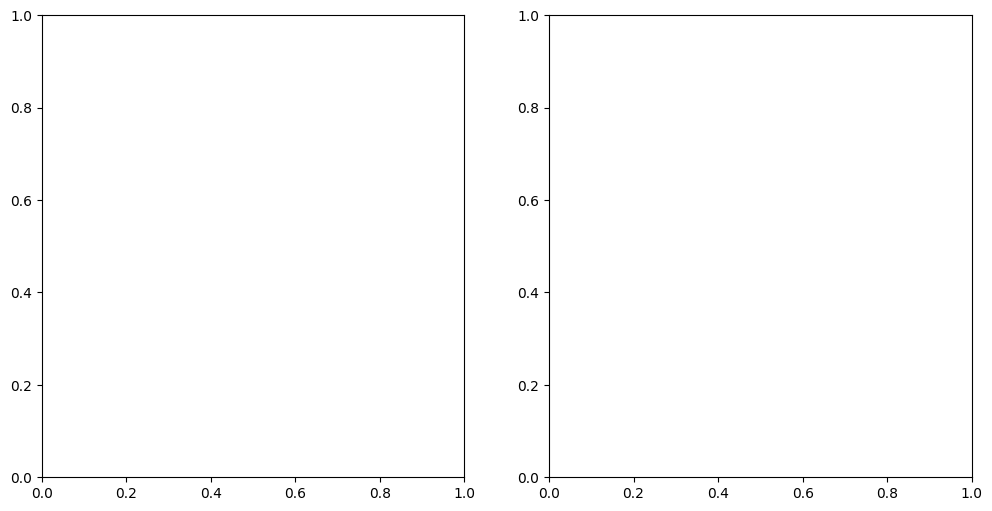

In [2]:
def laplacian2D(a, dx):
    return (
        - 4 * a
        + np.roll(a,1,axis=0) 
        + np.roll(a,-1,axis=0)
        + np.roll(a,+1,axis=1)
        + np.roll(a,-1,axis=1)
    ) / (dx ** 2)

def random_initialiser(shape):
    return(
        np.random.normal(loc=0, scale=0.05, size=shape),
        np.random.normal(loc=0, scale=0.05, size=shape)
    )

class BaseStateSystem:
    """
    Base object for "State System".

    We are going to repeatedly visualise systems which are Markovian:
    the have a "state", the state evolves in discrete steps, and the next
    state only depends on the previous state.

    To make things simple, I'm going to use this class as an interface.
    """
    def __init__(self):
        raise NotImplementedError()

    def initialise(self):
        raise NotImplementedError()

    def initialise_figure(self):
        fig, ax = plt.subplots()
        return fig, ax

    def update(self):
        raise NotImplementedError()

    def draw(self, ax):
        raise NotImplementedError()

    def plot_time_evolution(self, filename, n_steps=30):
        """
        Creates a gif from the time evolution of a basic state syste.
        """
        self.initialise()
        fig, ax = self.initialise_figure()

        def step(t):
            self.update()
            self.draw(ax)

        anim = animation.FuncAnimation(fig, step, frames=np.arange(n_steps), interval=20)
        anim.save(filename=filename, dpi=60, fps=10, writer='imagemagick')
        plt.close()
        
    def plot_evolution_outcome(self, filename, n_steps):
        """
        Evolves and save the outcome of evolving the system for n_steps
        """
        self.initialise()
        fig, ax = self.initialise_figure()
        
        for _ in range(n_steps):
            self.update()

        self.draw(ax)
        fig.savefig(filename)
        plt.close()

class TwoDimensionalRDEquations(BaseStateSystem):
    def __init__(self, Da, Db, Ra, Rb,
                 initialiser=random_initialiser,
                 width=1000, height=1000,
                 dx=1, dt=0.1, steps=1):
        
        self.Da = Da
        self.Db = Db
        self.Ra = Ra
        self.Rb = Rb

        self.initialiser = initialiser
        self.width = width
        self.height = height
        self.shape = (width, height)
        self.dx = dx
        self.dt = dt
        self.steps = steps
        
    def initialise(self):
        self.t = 0
        self.a, self.b = self.initialiser(self.shape)
        
    def update(self):
        for _ in range(self.steps):
            self.t += self.dt
            self._update()

    def _update(self):
        
        # unpack so we don't have to keep writing "self"
        a,b,Da,Db,Ra,Rb,dt,dx = (
            self.a, self.b,
            self.Da, self.Db,
            self.Ra, self.Rb,
            self.dt, self.dx
        )
        
        La = laplacian2D(a, dx)
        Lb = laplacian2D(b, dx)
        
        delta_a = dt * (Da * La + Ra(a,b))
        delta_b = dt * (Db * Lb + Rb(a,b))
        
        self.a += delta_a
        self.b += delta_b
        
    def draw(self, ax):
        ax[0].clear()
        ax[1].clear()

        ax[0].imshow(self.a, cmap='jet')
        ax[1].imshow(self.b, cmap='brg')
        
        
        ax[0].set_title("A, t = {:.2f}".format(self.t))
        ax[1].set_title("B, t = {:.2f}".format(self.t))
        
    def initialise_figure(self):
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
        return fig, ax
    

def Ra(a,b): return a - a ** 3 - b + alpha
def Rb(a,b): return (a - b) * beta


rd = TwoDimensionalRDEquations(
    Da, Db, Ra, Rb, 
    width=width, height=width, 
    dx=dx, dt=dt, steps=100
)

rd.plot_evolution_outcome("2dRD.png", n_steps=150)
plt.imshow(normalize(rd.a)*255)
plt.colorbar()

In [ ]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from typing import Tuple

def normalize(image: np.ndarray) -> np.ndarray:
    """
    Normalize the image to have values between 0 and 1.
    
    Parameters:
    image (numpy.ndarray): The input image to be normalized.
    
    Returns:
    numpy.ndarray: The normalized image.
    """
    min_val = image.min()
    max_val = image.max()
    normalized_image = (image - min_val) / (max_val - min_val)
    return normalized_image

def generate_halftone(input_image: np.ndarray, dot_size: int = 10, ellipse_ratio: float = 0.5, chaos_factor: float = 0.5) -> Image:
    """
    Generate a halftone-like version of the input image with a chaotic pattern.
    
    Parameters:
    input_image (np.ndarray): The input image to be converted to halftone.
    dot_size (int): The size of the dots in the halftone pattern.
    ellipse_ratio (float): The ratio of the ellipse's height to its width.
    chaos_factor (float): The factor determining the randomness of the ellipse centers.
    
    Returns:
    PIL.Image: The halftone image.
    """
    # Normalize the input image to have values between 0 and 1
    normalized_image = normalize(input_image)
    
    # Convert the normalized image to a PIL image
    image = Image.fromarray((normalized_image * 255).astype(np.uint8)).convert('L')
    width, height = image.size

    # Create a new image for the halftone effect
    halftone_image = Image.new('L', (width, height), 255)
    draw = ImageDraw.Draw(halftone_image)

    # Loop through the image in steps of dot_size
    for y in range(0, height, dot_size):
        for x in range(0, width, dot_size):
            # Get the average brightness of the current block
            block = image.crop((x, y, x + dot_size, y + dot_size))
            average_brightness = sum(block.getdata()) / (dot_size * dot_size)

            # Calculate the radius of the ellipse based on the brightness
            radius_x = (1 - average_brightness / 255) * (dot_size / 2)
            radius_y = radius_x * ellipse_ratio  # Adjust the ratio for ellipse

            # Introduce randomness to the center of the ellipse
            center_x = x + dot_size / 2 + np.random.uniform(-chaos_factor * dot_size, chaos_factor * dot_size)
            center_y = y + dot_size / 2 + np.random.uniform(-chaos_factor * dot_size, chaos_factor * dot_size)

            # Draw the ellipse
            draw.ellipse(
                (center_x - radius_x, center_y - radius_y,
                 center_x + radius_x, center_y + radius_y),
                fill=0
            )

    return halftone_image

# Example usage
norm_image = normalize(rd.a)
halftone_image = generate_halftone(norm_image, dot_size=10, ellipse_ratio=1, chaos_factor=0.1)
plt.imshow(halftone_image, cmap="Greys_r")
plt.show()


In [ ]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from typing import Tuple

def normalize(image: np.ndarray) -> np.ndarray:
    """
    Normalize the image to have values between 0 and 1.
    
    Parameters:
    image (numpy.ndarray): The input image to be normalized.
    
    Returns:
    numpy.ndarray: The normalized image.
    """
    min_val = image.min()
    max_val = image.max()
    normalized_image = (image - min_val) / (max_val - min_val)
    return normalized_image

def generate_halftone(input_image: np.ndarray, dot_size: int = 10, chaos_factor: float = 0.5, divide: float =4) -> Image:
    """
    Generate a halftone-like version of the input image with a chaotic pattern using squares.
    
    Parameters:
    input_image (np.ndarray): The input image to be converted to halftone.
    dot_size (int): The size of the dots in the halftone pattern.
    chaos_factor (float): The factor determining the randomness of the square centers.
    
    Returns:
    PIL.Image: The halftone image.
    """
    # Normalize the input image to have values between 0 and 1
    normalized_image = normalize(input_image)
    
    # Convert the normalized image to a PIL image
    image = Image.fromarray((normalized_image * 255).astype(np.uint8)).convert('L')
    width, height = image.size

    # Create a new image for the halftone effect
    halftone_image = Image.new('L', (width, height), 255)
    draw = ImageDraw.Draw(halftone_image)

    # Loop through the image in steps of dot_size
    for y in range(0, height, dot_size):
        for x in range(0, width, dot_size):
            # Get the average brightness of the current block
            block = image.crop((x, y, x + dot_size, y + dot_size))
            average_brightness = sum(block.getdata()) / (dot_size * dot_size)

            # Calculate the size of the square based on the brightness
            base_square_size = (1 - average_brightness / 255) * dot_size

            # Introduce randomness to the size of the square
            square_size = base_square_size * (1 + np.random.uniform(-chaos_factor, chaos_factor))

            # Introduce randomness to the center of the square
            center_x = x + dot_size / 2 + np.random.uniform(-chaos_factor * dot_size, chaos_factor * dot_size)
            center_y = y + dot_size / 2 + np.random.uniform(-chaos_factor * dot_size, chaos_factor * dot_size)

            # Draw the square
            draw.rectangle(
                (center_x - square_size / divide, center_y - square_size / divide,
                 center_x + square_size / divide, center_y + square_size / divide),
                fill=0
            )

    return halftone_image

# Example usage
norm_image = normalize(rd.a)
halftone_image = generate_halftone(norm_image, dot_size=10, chaos_factor=0.2, divide=2)
plt.figure(dpi=150)
plt.imshow(halftone_image, cmap="Greys_r")
plt.show()

In [ ]:
halftone_image = Image.new('L', (100, 100), 255)
draw = ImageDraw.Draw(halftone_image)
draw.ellipse??

In [ ]:
halftone_image = Image.new('L', (100, 100), 255)
draw = ImageDraw.Draw(halftone_image)
draw.ellipse??

In [ ]:
import os
from skimage import io
import skimage.transform
print(os.getcwd())

seg_mask = io.imread("/Users/mr/Downloads/MP6843_seg/F01_120_GT_01.tif")
gray_image = skimage.color.rgb2gray(seg_mask)
threshold = skimage.filters.threshold_otsu(gray_image)
binary_mask = gray_image > threshold

rescaled_image = skimage.transform.rescale(binary_mask, scale=2, anti_aliasing=False)
v.add_labels(skimage.measure.label(rescaled_image))
im_1 = io.imread("/Users/mr/Downloads/MP6843_img_full/F01_120w2.tif")
im_2 = io.imread("/Users/mr/Downloads/MP6843_img_full/F01_120w1.tif")
v.add_image(im_1)
v.add_image(im_2)


In [ ]:
696*2